# Convert crazy text file into xarray Dataset, save as NetCDF

Note that I used the `get_tao.sh` after un-tar'ing/and unzipping the `MRB_CSV.tar.gz` tarball that they gave us...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import re

In [2]:
plt.style.use('thesis')

Read from the csv file

In [3]:
readdict = {'Latitude': lambda line : float(line.split(',decimal')[0].split(' ')[-1]),
        'Longitude': lambda line : float(line.split(',decimal')[0].split(' ')[-1]),
        'Year': lambda line : int(line.split(',,,')[0].split(' ')[-1]),
        'Month': lambda line : int(line.split(',,,')[0].split(' ')[-1]),
        'Day': lambda line : int(line.split(',,,')[0].split(' ')[-1]),
       }

In [4]:
def parse_ts(line, index):
    result = np.nan
    split = line.split(',')
    length_correct = index<len(split) and len(split) == 11
    if length_correct:
        val = split[index]
        no_illegal_chars = not any(x in val for x in ['-0-','\n'])
        result = float(val) if no_illegal_chars else np.nan
    
    return result

In [5]:
def read_file(fname, read):
    tao = {key:[] for key in read.keys()}
    counter = {key:[] for key in read.keys()}
    tao['Depth'] = np.concatenate([np.arange(0, 100, 5), np.arange(100, 500,25), np.arange(500,755, 50)])
    tao['Temperature'] = []
    tao['Salinity'] = []
    
    counter['Temperature'] = []
    counter['Salinity'] = []
    
    profile_index = 0
    line_no = 0
    with open(fname,'r') as f:
        for line in f:
            line_no+=1
            if line[:81] == '#--------------------------------------------------------------------------------':
                
                # Reset T/S containers
                ts_idx = 0
                this_temp = np.full_like(tao['Depth'], np.nan, dtype=np.float64)
                this_salt = np.full_like(tao['Depth'], np.nan, dtype=np.float64)
                
                # Read line for variables
                while True:
                    line = next(f)
                    line_no+=1
                    
                    if "END OF VARIABLES SECTION" in line:
                        
                        # Fill T/S with what we found (if we didn't find it, we have NaNs!)
                        tao['Temperature'].append(this_temp.copy())
                        tao['Salinity'].append(this_salt.copy())
                        counter['Temperature'].append(profile_index)
                        counter['Salinity'].append(profile_index)
                        
                        # check for variables we missed, if missed, increment counter and variable iwth NaN
                        for key in read.keys():
                            latest = counter[key][-1]
                            if latest != profile_index:
                                tao[key].append(np.nan)
                                counter[key].append(profile_index)
                                
                        # --- Check counter values
                        try:
                            assert counter['Latitude'][-1] == counter['Temperature'][-1]
                        except:
                            print(" ** Counter values are inconsistent **")
                            print("Line: ",line_no)
                            print("Counters:")
                            for key, val in counter.items():
                                print(f"\t{key}: {val[-1]}")
                            print("Values:")
                            for key, val in tao.items():
                                print(f"\t{key}: {val[-1]}")
                            raise
                            
                        # --- Check length
                        try:
                            assert len(counter['Latitude']) == len(counter['Temperature'])
                        except:
                            print(" ** Counter lengths are inconsistent")
                            print("Line: ",line_no)
                            print("Counters:")
                            for key, val in counter.items():
                                print(f"\t{key}: {val[-1]}")
                            print("Values:")
                            for key, val in tao.items():
                                print(f"\t{key}: {val[-1]}")
                            raise
                                
                        # prepare for next round
                        profile_index += 1
                        break
                    else:
                        # read line
                        
                        # First, look for easy stuff
                        if any(key in line for key in read.keys()):
                            for key, readme in read.items():
                                if key in line:
                                    tao[key].append(readme(line))
                                    counter[key].append(profile_index)
                                    
                        # Assume leading whitespace is Depth/T/S data
                        elif line[:5] == '     ':
                            try:
                                this_temp[ts_idx] = parse_ts(line, 4)
                                this_salt[ts_idx] = parse_ts(line, 7)
                            except IndexError:
                                print(f"line: {line_no}, ts_idx: {ts_idx}")
                                for key, val in tao.items():
                                    print(f"{key}[-1]: {val[-1]}")
                                raise
                            ts_idx += 1
    return tao, counter

In [6]:
from copy import deepcopy

In [11]:
alldata = []
for i in range(1,8):
    tao, cc = read_file(f'MRB_CSV/tao_data.{i}.txt', readdict)
    alldata.append(deepcopy(tao))
    print(f"{i}. Latitude: {len(tao['Latitude'])}, Temperature: {len(tao['Temperature'])}")

1. Latitude: 76988, Temperature: 76988
2. Latitude: 8620, Temperature: 8620
3. Latitude: 8686, Temperature: 8686
4. Latitude: 9586, Temperature: 9586
5. Latitude: 60071, Temperature: 60071
6. Latitude: 66991, Temperature: 66991
7. Latitude: 27012, Temperature: 27012


## Create xarray dataset

In [14]:
def make_dataset(td):
    
    # Make np.datetime64 date
    date = [np.datetime64(f'{Y}-{M:02d}-{D:02d}') for Y,M,D in zip(td['Year'],td['Month'],td['Day'])]
    xds = xr.Dataset()
    xds['time'] = xr.DataArray(date, coords={'time':date}, dims=('time',))
    xds['lat'] = xr.DataArray(td['Latitude'], coords=xds['time'].coords, dims=xds['time'].dims,
                             attrs={'long_name':'Latitude', 'units':'Degrees North'})
    xds['lon'] = xr.DataArray(td['Longitude'], coords=xds['time'].coords, dims=xds['time'].dims,
                             attrs={'long_name':'Longitude', 'units':'Degrees East'})
    
    xds['depth'] = xr.DataArray(td['Depth'], coords={'depth': td['Depth']}, dims=('depth',),
                             attrs={'long_name':'Depth', 'units':'m'})
    
    xdalike = xds.depth.broadcast_like(xds['time'])
    xds['temperature'] = xr.DataArray(td['Temperature'], coords=xdalike.coords, dims=xdalike.dims,
                                     attrs={'long_name':'Temperature', 'units':'degC', 'long_units':'degrees Celsius'})
    xds['salinity'] = xr.DataArray(td['Salinity'], coords=xdalike.coords, dims=xdalike.dims,
                                     attrs={'long_name':'Salinity', 'units':'PSS', 'long_units':'Practical Salinity Scale'})
    return xds

In [15]:
dslist = []
for tao in alldata:
    dslist.append(make_dataset(tao))

In [17]:
ds = xr.concat(dslist, dim='time')

In [21]:
ds = ds.sortby('time')

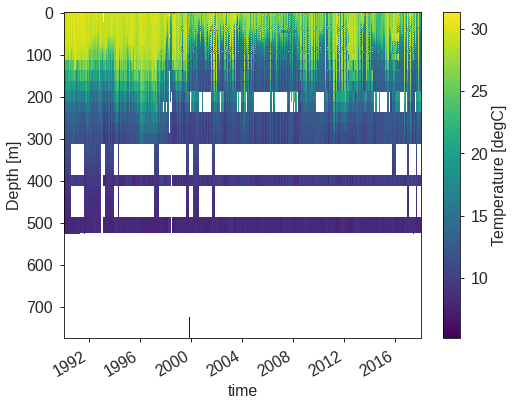

In [22]:
ds.temperature.plot(x='time',yincrease=False)

## Make a plot of locations

In [31]:
ticks = np.linspace(0,len(ds['time'])-1,5)
ticklabels = [str(ds['time'].values[int(tt)])[:10] for tt in ticks]

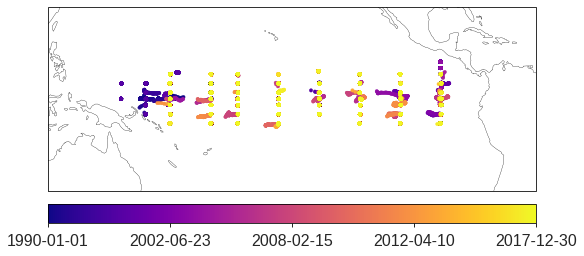

In [33]:
fig, ax = plt.subplots(constrained_layout=True,
                       subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)})

ax.set_extent([-240, -60, -30, 30], crs=ccrs.PlateCarree())

mappable = ax.scatter(ds['lon'],ds['lat'], c=range(len(ds['time'])),
                      marker='.',
                      cmap='plasma',
                      transform=ccrs.PlateCarree())
ax.coastlines()
cbar = fig.colorbar(mappable,ticks=ticks, orientation='horizontal')
cbar.ax.set_xticklabels(ticklabels);

fig.savefig('../figures/tao_locations.jpg',bbox_inches='tight',dpi=300)

## Save that data!

In [34]:
ds.to_netcdf('../ncfiles/tao_in_eccov4r4.nc')